In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry
import sys
import shapely.ops as so

In [2]:
def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [3]:
"""Initial Setup"""
# Position
x0 = 0
xf = 30
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 10000
iter_max = 1000
tMax = 20
vmax = 2
max_time = 5

def generate_map(num_obs, tempt, min_period, max_period, min_thickness, max_thickness):
    # Obstacle Setting
    # num_obs = rn.randint(5, 8)
    # num_obs = 8
    xobs_thickness = []
    for i in range(num_obs):
        xobs_thickness.append(rn.uniform(min_thickness, max_thickness))
    xobs = []
    while len(xobs) < num_obs:
        for i in range(num_obs):
            if len(xobs) == num_obs:
                break
            temp = rn.uniform(x0+1, xf-3)
            xobs_i = [temp, temp+xobs_thickness[i]]
            if len(xobs) == 0:
                xobs.append(xobs_i)
            else:
                overlap_check = []
                for ii in range(len(xobs)):
                    if np.abs(xobs_i[0] - xobs[ii][0]) >= 2:
                        overlap_check.append(1)
                    else:
                        overlap_check.append(0)
                if sum(overlap_check) == len(xobs):
                    xobs.append(xobs_i)
    # [start, close, open]
    obs_vec = []
    # min_period = 15
    # max_period = 20
    for i in range(num_obs):
        random_period = rn.uniform(min_period, max_period)
        thickness_i = xobs_thickness[i]
        # tempt = 10
        # temp = rn.uniform((thickness_i/vmax)+tempt, random_period-tempt)
        temp = rn.uniform(min_period-tempt, max_period-tempt)
        # print([(thickness_i/vmax)+tempt, random_period-tempt])
        obs_vec.append([0, temp, random_period-temp])
    return num_obs, xobs, obs_vec

Text(0, 0.5, 't')

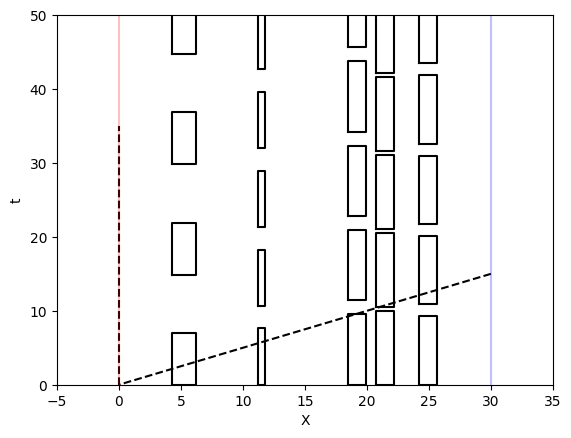

In [4]:
# TODO:
# Find minimum gap between obstacle given thickness and vmax
num_obs, xobs, obs_vec = generate_map(5, 5, 10, 15, 0.5, 2)

fig = plt.figure()
ax = fig.subplots()
t_temp = 50
# Obstacle
tspace = np.linspace(0, t_temp, 100)
for i in range(num_obs):
    obs_number = int((t_temp//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

point1 = [x0, 0]
point2 = [xf, t_temp]
# point3 = [-vmax/2*(t_temp - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(t_temp - 1/vmax*(xf+x0)))+x0/vmax]
# point4 = [vmax/2*(t_temp + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(t_temp + 1/vmax*(xf+x0))) - x0/vmax]
point3 = [x0, (x0-xf/vmax)+t_temp]
point4 = [xf, xf/vmax]

plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Initial/Final
plt.plot([x0, x0], [0, t_temp+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, t_temp+5], 'b-', alpha=0.25)

# Plot Limits
plt.xlim(x0-5, xf+5)
plt.ylim(0, t_temp)
plt.xlabel('X')
plt.ylabel('t')

In [5]:
def distance(a, b):
    return b - a

In [6]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [7]:
# def random_sample():
#     # Deprecated
#     trand = rn.uniform(1e-1, tMax)
#     check = rn.uniform(0, 1)
    
#     if check >= 0 and check < 0.9:
#         xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
#     elif check >= 0.9:
#         xrand = xf
#         trand = xf
#     qrand = [xrand, trand]
#     return qrand

def random_sample():
    n = 1
    trand = rn.uniform(0, 1e3)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [-vmax/2*(trand - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(trand - 1/vmax*(xf+x0)))+x0/vmax]
        point3 = [vmax/2*(trand + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(trand + 1/vmax*(xf+x0))) - x0/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    # print('xrand, trand: ', xrand, trand)
    return [xrand, trand]

In [8]:
def check_route(q1, q2, t1):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((t1//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [9]:
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    # print('dx, dt: ', dx, dt)
    if dt > 0 and np.abs(dx/dt) <= vmax:
        return True
    else:
        return False

In [10]:
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for vi in V:
        if reachable(vi, qrand):
            dist_vec.append(np.sqrt((vi[0]-qrand[0])**2 + (vi[1]-qrand[1])**2))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [11]:
def extend(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [12]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [13]:
"""Standard RRT"""
def standard_RRT(compTimeLimit):
    total_path_time = 0
    total_path_distance = 0
    k = 0
    V_RRT = []
    V_RRT.append([x0, 0])
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []

    path_RRT = None
    # while k < K:
    start = time.time()
    while 1:
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route(qclosest, qnew, qrand[1]):
                    break

        # Add V, E
        k += 1
        V_RRT.append(qnew)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[1])

        # Check continue
        if np.abs(distance(xf, qnew[0])) <= 1:
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            path_RRT = find_path(xf, E_RRT)
            for fpv in range(len(path_RRT)-1):
                total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
                total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
            break

        if time.time()-start > compTimeLimit:
            break
    end = time.time()

    if path_RRT is not None:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRT, V_RRT, E_RRT, T_RRT
    else:
        return False, end-start, total_path_distance, total_path_time, 0, path_RRT, V_RRT, E_RRT, T_RRT

In [14]:
# start = time.time()
# print('RRT')
# pathFound, time_RRT, RRTstar_total_distance, RRTstar_total_time, success_RRT, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(20)
# print(time.time()-start)

# fig = plt.figure()
# ax = fig.subplots()
# tf = V_RRT[-1][1]
# # RRT
# for rrtv in V_RRT:
#     plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
# for rrte in E_RRT:
#     plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# # Obstacle
# tspace = np.linspace(0, tf+5, 100)
# for i in range(len(xobs)):
#     obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
#     for j in range(obs_number):
#         this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
#         plt.plot(*this_obstacle.exterior.xy, 'k')

# Path
# if path_RRT is not None:
#     for pathi in path_RRT:
#         plt.plot(pathi[0], pathi[1], '.g')
#     for pathi in range(len(path_RRT)-1):
#         plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# # Initial/Final
# plt.plot([x0, x0], [0, max(T_RRT)+5], 'm-', alpha=0.25)
# plt.plot([xf, xf], [0, max(T_RRT)+5], 'c-', alpha=0.25)

# # Plot Limits
# #plt.xlim(xf[0]-1, xf+1)
# plt.ylim(0, max(T_RRT)+5)
# plt.xlabel('X')
# plt.ylabel('t')
# plt.grid()

In [15]:
# path_found, compTime, RRT_total_distance, RRT_total_time, success, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(compTimeLimit=0.5)
# print('Path Found?: ', path_found)
# print('Computation Time: ', compTime)
# print('RRT_total_distance: ', RRT_total_distance)

In [16]:
def neighbors(prox, q0, V_RRTstar):
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(q0, v):
            output.append(v)
    return output

In [17]:
"""Stardard RRT*"""
def standard_RRTstar(compTimeLimit):
    K = 10000
    total_path_time = 0
    total_path_distance = 0
    success_RRTstar = 0

    # print('iter: ', iter)
    k = 0
    V_RRTstar = []
    V_RRTstar.append([x0, 0])
    T_RRTstar = []
    T_RRTstar.append(0)
    E_RRTstar = []
    path_RRTstar = None
    start = time.time()
    while 1:
        while 1:
            if time.time()-start > compTimeLimit:
                break
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar)
            if time.time()-start > compTimeLimit:
                break
            if qclosest is not None:
                qnew = extend(qclosest, qrand, max_time)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew, qrand[1]):
                        break
        if time.time()-start > compTimeLimit:
            break
        # Add V, E
        k += 1
        V_RRTstar.append(qnew)
        E_RRTstar.append([qclosest, qnew])
        T_RRTstar.append(qnew[1])

        # Rewiring
        if k > 1:
            if time.time()-start > compTimeLimit:
                break
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(prox, qnew, V_RRTstar)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar.append([qnew, qmin])
        if time.time()-start > compTimeLimit:
            break
        # Check continue
        if np.abs(distance(xf, V_RRTstar[-1][0])) <= 1:
            if time.time()-start > compTimeLimit:
                break
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar.append(qfin)
            E_RRTstar.append([qnew, qfin])
            success_RRTstar += 1
            path_RRTstar = find_path(xf, E_RRTstar)
            for fpv in range(len(path_RRTstar)-1):
                total_path_time += path_RRTstar[fpv+1][1]-path_RRTstar[fpv][1]
                total_path_distance += path_RRTstar[fpv+1][0]-path_RRTstar[fpv][0]
            break
        if time.time()-start > compTimeLimit:
            break
    end = time.time()

    if path_RRTstar is not None:
        return True, end-start, np.abs(total_path_distance), np.abs(total_path_time), 1, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar
    else:
        return False, end-start, total_path_distance, total_path_time, 0, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar

In [18]:
# pathFound, time, a, b, c, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(10)

# fig = plt.figure()
# ax = fig.subplots()
# tf = V_RRTstar[-1][1]
# # RRTstar
# for rrtv in V_RRTstar:
#     plt.plot(rrtv[0], rrtv[1], 'r.', alpha=0.25)
# for rrte in E_RRTstar:
#     plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.25)

# # Obstacle
# tspace = np.linspace(0, tf+5, 100)
# for i in range(len(xobs)):
#     obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
#     for j in range(obs_number):
#         this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
#         plt.plot(*this_obstacle.exterior.xy, 'k')

# # Path
# if path_RRTstar is not None:
#     for pathi in path_RRTstar:
#         plt.plot(pathi[0], pathi[1], '.g')
#     for pathi in range(len(path_RRTstar)-1):
#         plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# # Initial/Final
# plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
# plt.plot([xf, xf], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# # Plot Limits
# #plt.xlim(xf[0]-1, xf+1)
# plt.ylim(0, 200+5)
# plt.xlabel('X')
# plt.ylabel('t')
# # plt.grid()

In [19]:
# path_found, compTime, RRTstar_total_distance, RRTstar_total_time, success, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(compTimeLimit=1)
# print('Path Found?: ', path_found)
# print('Computation Time: ', compTime)
# print('RRT_total_distance: ', RRTstar_total_distance)

In [20]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [21]:
def reachable_RRTC(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    
    if dx == 0:
        return True
    else:
        if forward and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        elif not forward and np.abs(dx/dt) <= vmax and dt < 0:
            return True
        return False

In [22]:
def random_sample_RRTC(tf, n, k):
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal and n == 1:
        # IF not, sample goal
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    elif not sample_goal or n >= 1:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        # point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        # point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        point3 = [x0, (x0-xf/vmax)+tf]
        point4 = [xf, xf/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    return [xrand, trand]

In [23]:
# def extend(qclosest, q1, max_time):
#     dx = q1[0]-qclosest[0]
#     dt = q1[1]-qclosest[1]
#     max_distance = max_time

#     if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
#         qnew = q1
#     else:
#         norm = np.sqrt(dx**2 + dt**2)
#         dxnorm = dx/norm*max_distance
#         dtnorm = dt/norm*max_distance
#         qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
#     return qnew

In [24]:
def find_neighbor_RRTC(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(distance(V[i][0], qrand[0]))
        else:
            dist_vec.append(1e100)

    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [25]:
def check_route_test(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [26]:
def find_path_test(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break
        kek += 1

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [27]:
# Standard ST-RRT-Connect
def standard_RRTC(compTimeLimit):
    K = 2500
    total_path_time = 0
    total_path_distance = 0
    tf = xf/vmax + 10
    start = time.time()
    n = 4
    for kek in range(n):
        start_loop = time.time()
        final_path = None
        # print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf, tf])

        V_RRTCa_raw = []
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while 1:
            path_check = False
        # while k < K:
            # print('k: ', k)
            while 1:
                if (time.time()-start_loop) > (compTimeLimit/n):
                    break
                # Sample
                qrand = random_sample_RRTC(tf, 1, k)
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb, k)
                if (time.time()-start_loop) > (compTimeLimit/n):
                    break
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tf):
                            break
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
                V_RRTCa_raw.append(qrand)
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            # Check continue
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            break
            k += 1
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            if path_check:
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                final_path = list(reversed(patha)) + pathb                
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                break
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
        if path_check:
            break
        tf += 20
        if time.time()-start > compTimeLimit:
            break
    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb


In [28]:
def random_sample_RRTC_waitgo(qprev, tf, n, k, sample_rate_vec):
    what_to_sample = rn.uniform(0, 1)
    # what_to_sample = 0.95

    # Find a random point in a domain
    if what_to_sample <= sample_rate_vec[0]:
        # print('random')
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        # point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        # point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        point3 = [x0, (x0-xf/vmax)+tf]
        point4 = [xf, xf/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    elif what_to_sample > sample_rate_vec[0] and what_to_sample <= sample_rate_vec[0]+sample_rate_vec[1]:
        # print('stationary')
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = qprev[0]
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = qprev[0]
            trand = 0
    elif what_to_sample > sample_rate_vec[0]+sample_rate_vec[1] and what_to_sample <= 1:
        # IF not, sample goal
        # print('final')
        if np.mod(k, 2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    return [xrand, trand]

In [29]:
def extend_WG(qclosest, q1, max_time):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    max_distance = max_time

    if np.abs(dx) <= max_distance and np.abs(dt) <= max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2 + dt**2)
        dxnorm = dx/norm*max_distance
        dtnorm = dt/norm*max_distance
        qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [30]:
def find_neighbor_RRTC_WG(qrand, V, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(np.abs(distance(V[i][0], qrand[0])))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [31]:
# Standard ST-RRT-Connect Wait-Go
def standard_RRTC_waitgo(compTimeLimit, sample_rate_vec):
    total_path_time = 0
    max_time = 5
    total_path_distance = 0
    tf = xf/vmax + 10
    qprev_start = [x0, 0]
    qprev_goal = [xf, tf]
    start = time.time()
    n = 4
    V_RRTCa_All = {}
    V_RRTCb_All = {}
    T_RRTCa_All = {}
    T_RRTCb_All = {}
    E_RRTCa_All = {}
    E_RRTCb_All = {}
    for kek in range(n):
        start_loop = time.time()
        final_path = None
        # print('tf: ', tf)
        k = 0
        V_RRTCa = []
        V_RRTCa.append([x0, 0])
        V_RRTCb = []
        V_RRTCb.append([xf, tf])

        V_RRTCa_raw = []
        V_RRTCb_raw = []

        T_RRTCa = []
        T_RRTCb = []
        T_RRTCa.append(0)
        T_RRTCa.append(tf)

        E_RRTCa = []
        E_RRTCb = []

        while 1:
            path_check = False
        # while k < K:
            # print('k: ', k)
            while 1:
                if (time.time()-start_loop) > (compTimeLimit/n):
                    break
                # Sample
                if np.mod(k, 2) == 0:
                    qrand = random_sample_RRTC_waitgo(qprev_start, tf, 1, k, sample_rate_vec)
                else:
                    qrand = random_sample_RRTC_waitgo(qprev_goal, tf, 1, k, sample_rate_vec)
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC_WG(qrand, V_RRTCa, k)
                else:
                    qclosest = find_neighbor_RRTC_WG(qrand, V_RRTCb, k)
                if (time.time()-start_loop) > (compTimeLimit/n):
                    break
                if qclosest is not None:
                    qnew = extend_WG(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tf):
                            break
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
                V_RRTCa_raw.append(qrand)
                qprev_start = qnew
            else:
                V_RRTCb.append(qnew)
                E_RRTCb.append([qclosest, qnew])
                T_RRTCb.append(qnew[1])
                V_RRTCb_raw.append(qrand)
                qprev_goal = qnew
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            # Check continue
            if np.mod(k,2) == 0:
                for vj in V_RRTCb:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tf) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[-1], forward=False):
                        if check_route_test(vi, V_RRTCb[-1], tf) and reachable_RRTC(vi, V_RRTCb[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[-1]]
                            path_check = True
                            break
            k += 1
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
            if path_check:
                E_RRTC = E_RRTCa + E_RRTCb
                E_RRTC.append(connect_edge)
                patha = find_path_test([x0, 0], E_RRTC[-1][0], V_RRTCa, E_RRTCa, 0)
                pathb = find_path_test([xf, tf], E_RRTC[-1][1], V_RRTCb, E_RRTCb, 1)
                final_path = list(reversed(patha)) + pathb                
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                break
            if (time.time()-start_loop) > (compTimeLimit/n):
                break
        if path_check:
            V_RRTCa_All[str(kek)] = V_RRTCa
            V_RRTCb_All[str(kek)] = V_RRTCb
            T_RRTCa_All[str(kek)] = E_RRTCa
            T_RRTCb_All[str(kek)] = T_RRTCb
            E_RRTCa_All[str(kek)] = E_RRTCa
            E_RRTCb_All[str(kek)] = E_RRTCb
            break
        V_RRTCa_All[str(kek)] = V_RRTCa
        V_RRTCb_All[str(kek)] = V_RRTCb
        T_RRTCa_All[str(kek)] = E_RRTCa
        T_RRTCb_All[str(kek)] = T_RRTCb
        E_RRTCa_All[str(kek)] = E_RRTCa
        E_RRTCb_All[str(kek)] = E_RRTCb
        tf += 20
        if time.time()-start > compTimeLimit:
            break
    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa_All, V_RRTCb_All, E_RRTCa_All, E_RRTCb_All
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa_All, V_RRTCb_All, E_RRTCa_All, E_RRTCb_All


In [32]:
"""ST-RRT with Time Shadow"""
def isInside(A, B, C, x, y):
    # Decomposition
    x1 = A[0]
    y1 = A[1]
    x2 = B[0]
    y2 = B[1]
    x3 = C[0]
    y3 = C[1]

    c1 = (x2-x1)*(y-y1)-(y2-y1)*(x-x1)
    c2 = (x3-x2)*(y-y2)-(y3-y2)*(x-x2)
    c3 = (x1-x3)*(y-y3)-(y1-y3)*(x-x3)
    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        # In Triangle
        return True
    else:
        # Not in Triangle
        return False
    
def obstacle_check_timeshadow(q2, obs_pos, obs_t, forward= True):
    trand = q2[1]
    temp = trand - obs_t[0]
    tempt = np.mod(temp, obs_t[1]+obs_t[2])

    if tempt >= obs_t[1] and tempt <= (obs_t[1]+obs_t[2]):
        if forward:
            # Not Caught
            X1 = [obs_pos[0], obs_t[1]+obs_t[2]]
            X2 = [obs_pos[1], obs_t[1]+obs_t[2]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
        else:
            X1 = [obs_pos[0], obs_t[1]]
            X2 = [obs_pos[1], obs_t[1]]
            X3 = [obs_pos[0]+(obs_pos[1]-obs_pos[0])/2, (obs_pos[0]+(obs_pos[1]-obs_pos[0])/2)/vmax + (X1[1]-X1[0]/vmax)]

        if isInside(X1, X2, X3, q2[0], tempt):
            # Caught
            return False
        else:
            return True
    else:
        # Caught
        return False 
    
def validate_timeshadow(q2, k):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if np.mod(k,2) == 0:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], True):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
            else:
                if obstacle_check(q2[1], obs_vec[i]) and obstacle_check_timeshadow(q2, xobs[i], obs_vec[i], False):
                    check_vec.append(0)
                else:
                    check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle_timeshadow(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    timeblock = shapely.geometry.Polygon([point1, point2, point3, point4])

    # Downward Triangle
    X1 = [pos_obs[0], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X2 = [pos_obs[1], time_obs[0]+time_obs[1]+time_obs[2]+time_translate]
    X3 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X2[1]-X2[0]/vmax)]
    downTriangle = shapely.geometry.Polygon([X1, X2, X3])

    # Upward Triangle
    X4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]
    X5 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    X6 = [pos_obs[0]+(pos_obs[1]-pos_obs[0])/2, (pos_obs[0]+(pos_obs[1]-pos_obs[0])/2)/vmax + (X4[1]-X4[0]/vmax)]
    upperTriangle = shapely.geometry.Polygon([X4, X5, X6])

    return so.unary_union([timeblock, downTriangle, upperTriangle])

def check_route_test_timeshadow(q1, q2, tf):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((tf//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle_timeshadow(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [33]:
# Standard ST-RRT-Connect with Timeshadow
def RRTC_TS(compTimeLimit):
    K = 2500
    total_path_time = 0
    total_path_distance = 0
    tf = xf/vmax + 50
    start = time.time()
    for kek in range(4):
        # print('tf: ', tf)
        k = 0
        V_RRTCa_TS = []
        V_RRTCa_TS.append([x0, 0])
        V_RRTCb_TS = []
        V_RRTCb_TS.append([xf, tf])

        T_RRTCa_TS = []
        T_RRTCb_TS = []
        T_RRTCa_TS.append(0)
        T_RRTCa_TS.append(tf)

        E_RRTCa_TS = []
        E_RRTCb_TS = []

        while 1:
        # while k < K:
            while 1:
                # Sample
                qrand = random_sample_RRTC(tf, 1, k)
                
                if np.mod(k, 2) == 0:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCa_TS, k)
                else:
                    qclosest = find_neighbor_RRTC(qrand, V_RRTCb_TS, k)
                
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                    # Validate
                    check_vec = validate_timeshadow(qnew, k)
                    if np.sum(check_vec) == 0:
                        if check_route_test_timeshadow(qclosest, qnew, tf):
                            break
                
            # Add V, E
            if np.mod(k, 2) == 0:
                V_RRTCa_TS.append(qnew)
                E_RRTCa_TS.append([qclosest, qnew])
                T_RRTCa_TS.append(qnew[1])
            else:
                V_RRTCb_TS.append(qnew)
                E_RRTCb_TS.append([qclosest, qnew])
                T_RRTCb_TS.append(qnew[1])

            # Check continue
            path_check = False
            if np.mod(k,2) == 0:
                for vj in V_RRTCb_TS:
                    if reachable_RRTC(V_RRTCa_TS[-1], vj, forward=True):
                        if check_route_test_timeshadow(V_RRTCa_TS[-1], vj, tf) and reachable_RRTC(V_RRTCa_TS[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa_TS[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa_TS:
                    if reachable_RRTC(vi, V_RRTCb_TS[-1], forward=False):
                        if check_route_test_timeshadow(vi, V_RRTCb_TS[-1], tf) and reachable_RRTC(vi, V_RRTCb_TS[-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb_TS[-1]]
                            path_check = True
                            break
            k += 1

            if path_check:
                # print('Path Found')
                E_RRTC_TS = E_RRTCa_TS + E_RRTCb_TS
                E_RRTC_TS.append(connect_edge)
                patha = find_path_test([x0, 0], E_RRTC_TS[-1][0], V_RRTCa_TS, E_RRTCa_TS, 0)
                pathb = find_path_test([xf, tf], E_RRTC_TS[-1][1], V_RRTCb_TS, E_RRTCb_TS, 1)
                final_path = list(reversed(patha)) + pathb
                for fpv in range(len(final_path)-1):
                    total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                    total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
                break
            if time.time()-start > compTimeLimit:
                break

        # print('Path_check: ', path_check)
        if path_check:
            break
        tf += 20

    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS

In [34]:
def random_sample_RRT(tf):
    n = 1
    sample_goal = rn.uniform(0, 1) <= 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf
        trand = tf
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        # point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        # point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        point3 = [x0, (x0-xf/vmax)+tf]
        point4 = [xf, xf/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
    return [xrand, trand]

def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [35]:
# Standard ST-RRT
def RRTinTimeCone(compTimeLimit):
    # Allocate max iteration uniformly
    K = 2500
    tf = xf/vmax + 50
    path_RRT = None
    total_path_time = 0
    total_path_distance = 0

    # If RRT storages are here, it does not cancel
    V_RRT = []
    V_RRT.append([x0, 0])

    T_RRT = []
    T_RRT.append(0)

    E_RRT = []
    E_RRT = []
    start = time.time()
    for kek in range(4):
        # print('tf: ', tf)
        while 1:
            while 1:
                # Sample
                qrand = random_sample_RRT(tf)

                qclosest = find_neighbor_RRTC(qrand, V_RRT, 0)
                
                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tf):
                            break
            # Add V, E
            V_RRT.append(qnew)
            E_RRT.append([qclosest, qnew])
            T_RRT.append(qnew[1])
            # k += 1

            # Check continue
            if np.abs(distance(xf, qnew[0])) <= 1:
                dist_to_fin = distance(xf, qnew[0])
                qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
                V_RRT.append(qfin)
                E_RRT.append([qnew, qfin])
                path_RRT = find_path(xf, E_RRT)
                for fpv in range(len(path_RRT)-1):
                    total_path_time += (path_RRT[fpv+1][1]-path_RRT[fpv][1])
                    total_path_distance += np.abs(path_RRT[fpv+1][0]-path_RRT[fpv][0])
                break
            if time.time()-start > compTimeLimit:
                break
        if path_RRT is not None:
            break
        tf += 20
        
    end = time.time()
    # print('final time: ', end-start)
    if path_RRT is not None:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRT, V_RRT, E_RRT
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRT, E_RRT

In [36]:
def random_sample_RRTC_parallel(qprev, tf, n, n2, k, sample_rate_vec):
    what_to_sample = rn.uniform(0, 1)
    # what_to_sample = 0.95

    # Find a random point in a domain
    if what_to_sample <= sample_rate_vec[0]:
        # print('random')
        # Construct Points for Convex Hull
        point1 = [x0, 0]
        point2 = [xf, tf]
        # point3 = [-vmax/2*(tf - 1/vmax*(xf+x0)), -1/vmax*(-vmax/2*(tf - 1/vmax*(xf+x0)))+x0/vmax]
        # point4 = [vmax/2*(tf + 1/vmax*(xf+x0)), 1/vmax*(vmax/2*(tf + 1/vmax*(xf+x0))) - x0/vmax]
        point3 = [x0, (x0-xf/vmax)+tf]
        point4 = [xf, xf/vmax]

        # Convex hull
        hull = ConvexHull([point1, point2, point3, point4])
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        if n == 1:
            xrand = rand_points[0][0]
            trand = rand_points[0][1]
            return [xrand, trand]
        else:
            return rand_points
    else:
        # IF not, sample goal
        # print('final')
        if np.mod(k, n2) == 0: # Start from bottom tree (x0)
            xrand = xf
            trand = tf
        else:                 # Start from top tree (xf)
            xrand = x0
            trand = 0
    return [xrand, trand]

In [37]:
def find_neighbor_RRTC_parallel(qrand, V, n, k):
    # Find neighbor
    dist_vec = []
    if np.mod(k,n) == 0:
        forward = True
    else:
        forward = False

    for i in range(len(V)):
        if reachable_RRTC(V[i], qrand, forward):
            dist_vec.append(np.abs(distance(V[i][0], qrand[0])))
        else:
            dist_vec.append(1e100)
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [38]:
def find_path_test_parallel(vi, vf, V, E, trigger):
    # trigger:
    # 0 -> a
    # 1 -> b
    path_vec = []
    path_vec.append(vf)
    curr = vf
    kek = 0
    # print('start: ',curr)
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]            
            # print('e: ', e)
            # print('Edge: ', E[ei], ei)
            if np.abs(curr[0]-e[0]) <1e-4 and np.abs(curr[1]-e[1])<1e-4:
                # print('Edge: ', E[ei], ei)
                if trigger == 0:
                    curr = E[ei][0]
                else:
                    curr = E[ei][0]
                path_vec.append(curr)
                break        
        kek += 1

        # print('curr: ', curr)
        # if kek == 2:
        #     adfasdfasfasf

        if trigger == 0:
            if curr[0] == vi[0] and curr[1] == vi[1]:
                return path_vec
        elif trigger == 1:
            if np.abs(curr[0]-vi[0]) <= 0.1:
                return path_vec
            

In [43]:
# Standard RRT with Parallel
def standard_RRTC_Parallel(n, compTimeLimit, sample_rate_vec=[0.9, 0.1]):
    total_path_time = 0
    max_time = 5
    total_path_distance = 0
    tf0 = xf/vmax + 5
    tfn = xf/vmax + 100
    tfSelection = []
    for ii in range(n):
        tfSelection.append(rn.uniform(tf0, tfn))
    qprev_start = [x0, 0]
    qprev_goal = [xf, tfSelection[0]]
    k = 0
    V_RRTCa = []
    V_RRTCa.append([x0, 0])
    V_RRTCb = {}
    T_RRTCb = {}
    E_RRTCb = {}
    for ii in range(n):
        V_RRTCb[str(ii)] = []
        V_RRTCb[str(ii)].append([xf, tfSelection[ii]])
        T_RRTCb[str(ii)] = []
        T_RRTCb[str(ii)].append(tfSelection[ii])
        E_RRTCb[str(ii)] = []
    T_RRTCa = []
    T_RRTCa.append(0)
    E_RRTCa = []

    final_path = None
    path_check = False
    start = time.time()
    while 1:
        # print(time.time()-start)
        for ii in range(n):
            # print('tf: ', tfSelection[ii])
            while 1:
                if (time.time()-start) > (compTimeLimit):
                    break
                # Sample
                if np.mod(k, n) == 0:
                    qrand = random_sample_RRTC_parallel(qprev_start, tfSelection[ii], 1, n, k, sample_rate_vec)
                else:
                    qrand = random_sample_RRTC_parallel(qprev_goal, tfSelection[ii], 1, n, k, sample_rate_vec)
                if np.mod(k, n) == 0:
                    qclosest = find_neighbor_RRTC_parallel(qrand, V_RRTCa, n, k)
                else:
                    qclosest = find_neighbor_RRTC_parallel(qrand, V_RRTCb[str(ii)], n, k)
                if (time.time()-start) > (compTimeLimit):
                    break
                if qclosest is not None:
                    qnew = extend_WG(qclosest, qrand, max_time)
                        
                    # Validate
                    check_vec = validate(qnew)
                    if np.sum(check_vec) == 0:
                        if check_route_test(qclosest, qnew, tfSelection[ii]):
                            break
            # print(time.time()-start)
            if (time.time()-start) > (compTimeLimit):
                break
            # Add V, E
            if np.mod(k, n) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[1])
                qprev_start = qnew
            else:
                V_RRTCb[str(ii)].append(qnew)
                E_RRTCb[str(ii)].append([qclosest, qnew])
                T_RRTCb[str(ii)].append(qnew[1])
                qprev_goal = qnew
            if (time.time()-start) > (compTimeLimit):
                break
            # Check continue
            if np.mod(k,n) == 0:
                for vj in V_RRTCb[str(ii)]:
                    if reachable_RRTC(V_RRTCa[-1], vj, forward=True):
                        if check_route_test(V_RRTCa[-1], vj, tfSelection[ii]) and reachable_RRTC(V_RRTCa[-1], vj):# and np.abs(V_RRTCa[-1][1]-vj[1]) <= 5 
                            connect_edge = [V_RRTCa[-1], vj]
                            path_check = True
                            break
            else:
                for vi in V_RRTCa:
                    if reachable_RRTC(vi, V_RRTCb[str(ii)][-1], forward=False):
                        if check_route_test(vi, V_RRTCb[str(ii)][-1], tfSelection[ii]) and reachable_RRTC(vi, V_RRTCb[str(ii)][-1]):#and np.abs(V_RRTCb[-1][1]-vi[1]) <= 5 
                            connect_edge = [vi, V_RRTCb[str(ii)][-1]]
                            path_check = True
                            break
            if path_check:
                break
        k += 1
        # print(time.time()-start)
        if (time.time()-start) > (compTimeLimit):
            break
        if path_check:
            E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
            E_RRTC.append(connect_edge)
            # return True, 0, 0, 0, 1, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
            patha = find_path_test_parallel([x0, 0], connect_edge[0], V_RRTCa, E_RRTCa, 0)
            pathb = find_path_test_parallel([xf, tfSelection[ii]], connect_edge[1], V_RRTCb[str(ii)], E_RRTCb[str(ii)], 1)
            final_path = list(reversed(patha)) + pathb                
            for fpv in range(len(final_path)-1):
                total_path_time += (final_path[fpv+1][1]-final_path[fpv][1])
                total_path_distance += np.abs(final_path[fpv+1][0]-final_path[fpv][0])
            break
        # print(time.time()-start)
        if time.time()-start > compTimeLimit:
            break
    end = time.time()
    
    if path_check:
        return True, end-start, total_path_distance, total_path_time, 1, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, total_path_distance, total_path_time, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb


In [40]:
# Iteration Control
iter = 0
iter_max = 1

x0 = 0
xf = 30

# Computation Time Setting
k = 0
K = 31
computationTimeLimit_List = np.linspace(-2,2,K)
# print(10**computationTimeLimit_List)
# print((3*np.sum(10**computationTimeLimit_List)*iter_max)/60)
# computationTimeLimit_List = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# computationTimeLimit_List = [10]
# computationTimeLimit_List = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print((3*np.sum(computationTimeLimit_List)*iter_max)/3600)

-2.590520390792032e-18


In [65]:
# Iteration Control
iter = 0
iter_max = 1
vmax = 2.5

# x0 = 0
# xf = 30

# Computation Time Setting
# k = 0
# K = 13
computationTimeLimit_List = [10]

# Switch for Algorithms
# RRT, RRT*, RRTC, RRTCWG, RRTCTS, RRTCP
algorithmSwitch = [False, True, True, False, False, False, True]

# Storage
# Map
rrtMap = {}
rrtMap['obstacle_position'] = []
rrtMap['obstacle_period'] = []

# vertex
vertex = {}
vertex['RRT'] = {}
vertex['RRTTC'] = {}
vertex['RRTstar'] = {}
vertex['RRTCa'] = {}
vertex['RRTCb'] = {}
vertex['RRTCWGa'] = {}
vertex['RRTCWGb'] = {}
vertex['RRTCa_TS'] = {}
vertex['RRTCb_TS'] = {}
vertex['RRTCaTP'] = {}
vertex['RRTCbTP'] = {}

# edge
edge = {}
edge['RRT'] = {}
edge['RRTTC'] = {}
edge['RRTstar'] = {}
edge['RRTCa'] = {}
edge['RRTCb'] = {}
edge['RRTCWGa'] = {}
edge['RRTCWGb'] = {}
edge['RRTCa_TS'] = {}
edge['RRTCb_TS'] = {}
edge['RRTCaTP'] = {}
edge['RRTCbTP'] = {}

# time
timestorage = {}
timestorage['RRT'] = {}
timestorage['RRTstar'] = {}

# path
path = {}
path['RRT'] = {}
path['RRTTC'] = {}
path['RRTTCWG'] = {}
path['RRTstar'] = {}
path['RRTC'] = {}
path['RRTC_TS'] = {}
path['RRTCTP'] = {}

# Computation Time
compTime = {}
compTimeRRT = []
compTimeRRTstar = []
compTimeRRTC = []
compTimeRRTCWG = []
compTimeRRTCTS = []
compTimeRRTTC = []

compTimeSuccessRRTstar = []
compTimeSuccessRRTC = []
compTimeSuccessRRTCWG = []


# Path Time
pathTime = {}
pathTimeRRT = []
pathTimeRRTstar = []
pathTimeRRTC = []
pathTimeRRTCWG = []
pathTimeRRTCTS = []
pathTimeRRTTC = []

# Path Distance
pathDist = {}
pathDistRRT = []
pathDistRRTstar = []
pathDistRRTC = []
pathDistRRTCWG = []
pathDistRRTCTS = []
pathDistRRTTC = []

# Success Rate
successRate = {}
successRateRRT = 0
successRateRRTstar = 0
successRateRRTC = 0
successRateRRTCWG = 0
successRateRRTCTS = 0
successRateRRTTC = 0

compTime_obs = {}
compTimeSuccess_obs = {}
compTimeSuccess = {}
pathTime_obs = {}
pathDist_obs = {}
successRate_obs = {}

k = 0
# obstacle_number_vec = [5, 6, 7, 8]
# obstacle_number_vec = [5, 6, 7, 8, 9, 10]
obstacle_number_vec = [8]
# computationTimeLimit_List = [3]

# for iii in range(len(obstacle_number_vec)):
for iii in range(1):
    # indexObs = rn.randint(0, len(obstacle_number_vec))
    # num_obs = [indexObs]
    # print(num_obs)
    k = 0
    while k < len(computationTimeLimit_List):
        # Storage
        compTime_obs[str(num_obs)] = []
        compTimeSuccess_obs[str(num_obs)] = []
        pathTime_obs[str(num_obs)] = []
        pathDist_obs[str(num_obs)] = []
        successRate_obs[str(num_obs)] = []

        iter = 0
        # Computation Time
        compTimeRRT = []
        compTimeRRTstar = []
        compTimeRRTC = []
        compTimeRRTCWG = []
        compTimeRRTCTS = []
        compTimeRRTTC = []
        compTimeRRTCP = []
        compTimeRRTstar_success = []
        compTimeRRTC_success = []
        compTimeRRTCWG_success = []
        compTimeRRTCP_success = []

        # Path Time
        pathTimeRRT = []
        pathTimeRRTstar = []
        pathTimeRRTC = []
        pathTimeRRTCWG = []
        pathTimeRRTCTS = []
        pathTimeRRTTC = []
        pathTimeRRTCP = []

        # Path Distance
        pathDistRRT = []
        pathDistRRTstar = []
        pathDistRRTC = []
        pathDistRRTCWG = []
        pathDistRRTCTS = []
        pathDistRRTTC = []
        pathDistRRTCP = []

        # Success Rate
        successRateRRT = 0
        successRateRRTstar = 0
        successRateRRTC = 0
        successRateRRTCWG = 0
        successRateRRTCTS = 0
        successRateRRTTC = 0
        successRateRRTCP = 0
        
        # computationTimeLimit = 10**computationTimeLimit_List[k]
        computationTimeLimit = computationTimeLimit_List[k]
        # print('Computation Time Limit: ', computationTimeLimit)
        while iter < iter_max:
            iter_start = time.time()
            # print('Iter: ' + str(iter) + ' Max Computation Time: '+str(computationTimeLimit))
            # Generate Map
            # print('Map Generated')
            # indexObs = rn.randint(0, len(obstacle_number_vec)-1)
            # num_obs = obstacle_number_vec[indexObs]
            num_obs = 6
            num_obs, xobs, obs_vec = generate_map(num_obs, 5, 15, 20, 0.5, 2)
            rrtMap['obstacle_position'].append(xobs)
            rrtMap['obstacle_period'].append(obs_vec)
            # print('setup done')
            # ST-RRT* 1D Example Reconstruction
            # num_obs = 1
            # x0 = 0
            # xf = 15
            # xobs = [[6.25, 10-1.25]]
            # obs_vec = [[0, 5, 5]]

            """RRT"""
            if algorithmSwitch[0]:
                print('RRT')
                pathFound, time_RRT, RRT_total_distance, RRT_total_time, success_RRT, path_RRT, V_RRT, E_RRT, T_RRT = standard_RRT(computationTimeLimit)
                compTimeRRT.append(time_RRT)
                if pathFound:
                    pathTimeRRT.append(RRT_total_time)
                    pathDistRRT.append(np.abs(RRT_total_distance))
                successRateRRT += success_RRT

                # Store Returns
                vertex['RRT'][str(iter)] = V_RRT
                edge['RRT'][str(iter)] = E_RRT
                timestorage['RRT'][str(iter)] = T_RRT
                path['RRT'][str(iter)] = path_RRT
            
            """RRT*"""
            if algorithmSwitch[1]:
                # print('RRT*')
                pathFound, time_RRTstar, RRTstar_total_distance, RRTstar_total_time, success_RRTstar, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_RRTstar(computationTimeLimit)
                compTimeRRTstar.append(time_RRTstar)
                if pathFound:
                    pathTimeRRTstar.append(RRTstar_total_time)
                    pathDistRRTstar.append(RRTstar_total_distance)
                successRateRRTstar += success_RRTstar
                if success_RRTstar:
                    compTimeRRTstar_success.append(time_RRTstar)
                    compTimeSuccessRRTstar.append(time_RRTstar)

                # Store Returns
                vertex['RRTstar'][str(iter)] = V_RRTstar
                edge['RRTstar'][str(iter)] = E_RRTstar
                timestorage['RRTstar'][str(iter)] = T_RRTstar
                path['RRTstar'][str(iter)] = path_RRTstar

            """RRT-Connect"""
            if algorithmSwitch[2]:
                # print('RRT-Connect')
                # pathFound, time_RRTC, RRTC_total_distance, RRTC_total_time, success_RRTC, final_path, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb = standard_RRTC(computationTimeLimit)
                pathFound, time_RRTC, RRTC_total_distance, RRTC_total_time, success_RRTC, path_RRTC, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb = standard_RRTC_waitgo(computationTimeLimit, sample_rate_vec=[0.64, 0, 0.35])
                compTimeRRTC.append(time_RRTC)
                if pathFound:
                    pathTimeRRTC.append(RRTC_total_time)
                    pathDistRRTC.append(RRTC_total_distance)
                successRateRRTC += success_RRTC
                if success_RRTC:
                    compTimeRRTC_success.append(time_RRTC)
                    compTimeSuccessRRTC.append(time_RRTC)

                # Store Returns
                vertex['RRTCa'][str(iter)] = V_RRTCa
                vertex['RRTCb'][str(iter)] = V_RRTCb
                edge['RRTCa'][str(iter)] = E_RRTCa
                edge['RRTCb'][str(iter)] = E_RRTCb
                path['RRTC'][str(iter)] = path_RRTC

            """RRT-Connect with WaitGo"""
            if algorithmSwitch[3]:
                print('RRT-Connect WaitGo')
                path_foundWG, time_RRTCWG, RRTCWG_total_distance, RRTCWG_total_time, success_RRTCWG, path_RRTCWG, V_RRTCWGa, V_RRTCWGb, E_RRTCWGa, E_RRTCWGb = standard_RRTC_waitgo(computationTimeLimit, sample_rate_vec=[0.7, 0.2, 0.1])
                compTimeRRTCWG.append(time_RRTCWG)
                if pathFound:
                    pathTimeRRTCWG.append(RRTCWG_total_time)
                    pathDistRRTCWG.append(RRTCWG_total_distance)
                successRateRRTCWG += success_RRTCWG
                if success_RRTCWG:
                    compTimeRRTCWG_success.append(time_RRTCWG)
                    compTimeSuccessRRTCWG.append(time_RRTCWG)
                
                # Store Returns
                vertex['RRTCWGa'][str(iter)] = V_RRTCWGa
                vertex['RRTCWGb'][str(iter)] = V_RRTCWGb
                edge['RRTCWGa'][str(iter)] = E_RRTCWGa
                edge['RRTCWGb'][str(iter)] = E_RRTCWGb

            """RRT-Connect Timeshadow"""
            if algorithmSwitch[4]:
                print('RRT-Connect with Timeshadow')
                pathFound, time_RRTCTS, RRT_RS_total_distance, RRT_RS_total_time, success_RRTCTS, path_RRTC_TS, V_RRTCa_TS, V_RRTCb_TS, E_RRTCa_TS, E_RRTCb_TS = RRTC_TS(computationTimeLimit)
                compTimeRRTCTS.append(time_RRTCTS)
                if pathFound:
                    pathTimeRRTCTS.append(RRT_RS_total_time)
                    pathDistRRTCTS.append(RRT_RS_total_distance)
                successRateRRTCTS += success_RRTCTS

                # Store Returns
                vertex['RRTCa_TS'][str(iter)] = V_RRTCa_TS
                vertex['RRTCb_TS'][str(iter)] = V_RRTCb_TS
                edge['RRTCa_TS'][str(iter)] = E_RRTCa_TS
                edge['RRTCb_TS'][str(iter)] = E_RRTCb_TS
                path['RRTC_TS'][str(iter)] = path_RRTC_TS

            """RRT in Timecone"""
            if algorithmSwitch[5]:
                print('RRT in Timecone')
                pathFound, time_RRTTC, RRTTC_total_distance, RRTTC_total_time, success_RRTTC, path_RRTTC, V_RRTTC, E_RRTTC = RRTinTimeCone(computationTimeLimit)
                compTimeRRTTC.append(time_RRTTC)
                if pathFound:
                    pathTimeRRTTC.append(RRTTC_total_time)
                    pathDistRRTTC.append(np.abs(RRTTC_total_distance))
                successRateRRTTC += success_RRTTC

                # Store Returns
                vertex['RRTTC'][str(iter)] = V_RRTTC
                edge['RRTTC'][str(iter)] = E_RRTTC
                path['RRTTC'][str(iter)] = path_RRTTC

            """RRT-Connect with Parallel Goal Tree"""
            if algorithmSwitch[6]:
                nParallel = 5
                # print('RRT-Connect Parallel')
                # pathFound, time_RRTCP, RRTCP_total_distance, RRTCP_total_time, success_RRTCP, path_RRTCP, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb = RRTC_Parallel(5, computationTimeLimit)
                pathFound, time_RRTCP, RRTCP_total_distance, RRTCP_total_time, success_RRTCP, path_RRTCP, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb = standard_RRTC_Parallel(nParallel, computationTimeLimit)
                compTimeRRTCP.append(time_RRTCP)
                if pathFound:
                    pathTimeRRTCP.append(RRTCP_total_time)
                    pathDistRRTCP.append(RRTCP_total_distance)
                successRateRRTCP += success_RRTCP
                if success_RRTCP:
                    compTimeRRTCP_success.append(time_RRTCP)

                # Store Returns
                vertex['RRTCaTP'][str(iter)] = V_RRTCPa
                vertex['RRTCbTP'][str(iter)] = V_RRTCPb
                edge['RRTCaTP'][str(iter)] = E_RRTCPa
                edge['RRTCbTP'][str(iter)] = E_RRTCPb
                path['RRTCTP'][str(iter)] = path_RRTCP

            # Update Iteration
            iter += 1

        if len(compTimeRRTstar_success) == 0:
            RRTstar_success_comp = 0
        else:
            RRTstar_success_comp = sum(compTimeRRTstar_success)/len(compTimeRRTstar_success)
        if len(compTimeRRTC_success) == 0:
            RRTC_success_comp = 0
        else:
            RRTC_success_comp = sum(compTimeRRTC_success)/len(compTimeRRTC_success)
        if len(compTimeRRTCWG_success) == 0:
            RRTCWG_success_comp = 0
        else:
            RRTCWG_success_comp = sum(compTimeRRTCWG_success)/len(compTimeRRTCWG_success)
        if len(compTimeRRTCP_success) == 0:
            RRTCP_success_comp = 0
        else:
            RRTCP_success_comp = sum(compTimeRRTCP_success)/len(compTimeRRTCP_success)

        # table = [['', 'RRT', 'RRT*', 'RRT-Connect', 'RRT-Connect with Timeshadow', 'RRT with Timecone', 'RRT-Connect Parallel']]
        # table.append(['Success Rate', successRateRRT/iter_max, successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCTS/iter_max, successRateRRTTC/iter_max, successRateRRTCP/iter_max])
        # table.append(['Computation Time', sum(compTimeRRT)/len(compTimeRRT), sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCTS)/len(compTimeRRTCTS), sum(compTimeRRTTC)/len(compTimeRRTTC), sum(compTimeRRTCP)/len(compTimeRRTTC)])
        # table_pathTime = ['Mean Path Time']
        # table_pathDist = ['Mean Path Dist']
        table = [['', 'RRT*', 'RRT-Connect', 'RRT-Connect Parallel']]
        table.append(['Success Rate', successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCP/iter_max])
        table.append(['Computation Time', sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCP)/len(compTimeRRTCP)])
        table.append(['Computation Time (Successed)', RRTstar_success_comp, RRTC_success_comp, RRTCP_success_comp])
        # table_pathTime = ['Mean Path Time']
        # table_pathDist = ['Mean Path Dist']
        # table = [['', 'RRT-Connect', 'RRT-Connect Parallel']]
        # table.append(['Success Rate', successRateRRTC/iter_max, successRateRRTCWG/iter_max])
        # table.append(['Computation Time', sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCWG)/len(compTimeRRTCWG)])
        # table.append(['Computation Time (Successed)', RRTC_success_comp, RRTCWG_success_comp])
        table_pathTime = ['Mean Path Time']
        table_pathDist = ['Mean Path Dist']
        # if len(pathTimeRRT) > 0:
        #     pathTimeRRTavg = sum(pathTimeRRT)/len(pathTimeRRT)
        #     pathDistRRTavg = sum(pathDistRRT)/len(pathDistRRT)
        #     table_pathTime.append(pathTimeRRTavg)
        #     table_pathDist.append(pathDistRRTavg)
        # else:
        #     pathTimeRRTavg = 0
        #     pathDistRRTavg = 0
        #     table_pathTime.append(pathTimeRRTavg)
        #     table_pathDist.append(pathDistRRTavg)
        if len(pathTimeRRTstar) > 0:
            pathDistRRTstar = [i for i in pathDistRRTstar if i != 0]
            pathTimeRRTstar = [i for i in pathTimeRRTstar if i != 0]

            pathTimeRRTstaravg = sum(pathTimeRRTstar)/len(pathTimeRRTstar)
            pathDistRRTstaravg = sum(pathDistRRTstar)/len(pathDistRRTstar)
            table_pathTime.append(pathTimeRRTstaravg)
            table_pathDist.append(pathDistRRTstaravg)
        else:
            pathTimeRRTstaravg = 0
            pathDistRRTstaravg = 0
            table_pathTime.append(pathTimeRRTstaravg)
            table_pathDist.append(pathDistRRTstaravg)

        pathDistRRTC = [i for i in pathDistRRTC if i != 0]
        pathTimeRRTC = [i for i in pathTimeRRTC if i != 0]
        
        if len(pathTimeRRTC) > 0:
            pathTimeRRTCavg = sum(pathTimeRRTC)/len(pathTimeRRTC)
            pathDistRRTCavg = sum(pathDistRRTC)/len(pathDistRRTC)
            table_pathTime.append(pathTimeRRTCavg)
            table_pathDist.append(pathDistRRTCavg)
        else:
            pathTimeRRTCavg = 0
            pathDistRRTCavg = 0
            table_pathTime.append(pathTimeRRTCavg)
            table_pathDist.append(pathDistRRTCavg)

        # pathDistRRTCWG = [i for i in pathDistRRTCWG if i != 0]
        # pathTimeRRTCWG = [i for i in pathTimeRRTCWG if i != 0]
        # if len(pathTimeRRTCWG) > 0:
        #     pathTimeRRTCWGavg = sum(pathTimeRRTCWG)/len(pathTimeRRTCWG)
        #     pathDistRRTCWGavg = sum(pathDistRRTCWG)/len(pathDistRRTCWG)
        #     table_pathTime.append(pathTimeRRTCWGavg)
        #     table_pathDist.append(pathDistRRTCWGavg)
        # else:
        #     pathTimeRRTCWGavg = 0
        #     pathDistRRTCWGavg = 0
        #     table_pathTime.append(pathTimeRRTCWGavg)
        #     table_pathDist.append(pathDistRRTCWGavg)
        # if len(pathTimeRRTCTS) > 0:
        #     pathTimeRRTCTSavg = sum(pathTimeRRTCTS)/len(pathTimeRRTCTS)
        #     pathDistRRTCTSavg = sum(pathDistRRTCTS)/len(pathDistRRTCTS)
        #     table_pathTime.append(pathTimeRRTCTSavg)
        #     table_pathDist.append(pathDistRRTCTSavg)
        # else:
        #     pathTimeRRTCTSavg = 0
        #     pathDistRRTCTSavg = 0
        #     table_pathTime.append(pathTimeRRTCTSavg)
        #     table_pathDist.append(pathDistRRTCTSavg)
        # if len(pathTimeRRTTC) > 0:
        #     pathTimeRRTTCavg = sum(pathTimeRRTTC)/len(pathTimeRRTTC)
        #     pathDistRRTTCavg = sum(pathDistRRTTC)/len(pathDistRRTTC)
        #     table_pathTime.append(pathTimeRRTTCavg)
        #     table_pathDist.append(pathDistRRTTCavg)
        # else:
        #     pathTimeRRTTCavg = 0
        #     pathDistRRTTCavg = 0
        #     table_pathTime.append(pathTimeRRTTCavg)
        #     table_pathDist.append(pathDistRRTTCavg)
        if len(pathTimeRRTCP) > 0:
            pathTimeRRTCPavg = sum(pathTimeRRTCP)/len(pathTimeRRTCP)
            pathDistRRTCPavg = sum(pathDistRRTCP)/len(pathDistRRTCP)
            table_pathTime.append(pathTimeRRTCPavg)
            table_pathDist.append(pathDistRRTCPavg)
        else:
            pathTimeRRTCPavg = 0
            pathDistRRTCPavg = 0
            table_pathTime.append(pathTimeRRTCPavg)
            table_pathDist.append(pathDistRRTCPavg)

        table.append(table_pathDist)
        table.append(table_pathTime)
        # compTime[str(k)] = [sum(compTimeRRT)/len(compTimeRRT), sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCTS)/len(compTimeRRTCTS), sum(compTimeRRTTC)/len(compTimeRRTTC), sum(compTimeRRTCP)/len(compTimeRRTCP)]
        # pathTime[str(k)] = [pathTimeRRTavg, pathTimeRRTstaravg, pathTimeRRTCavg, pathTimeRRTCTSavg, pathTimeRRTTCavg, pathTimeRRTCPavg]
        # pathDist[str(k)] = [np.abs(pathDistRRTavg), pathDistRRTstaravg, pathDistRRTCavg, pathDistRRTCTSavg, np.abs(pathDistRRTTCavg), np.abs(pathDistRRTCPavg)]
        # successRate[str(k)] = [successRateRRT/iter_max, successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCTS/iter_max, successRateRRTTC/iter_max, successRateRRTCP/iter_max]
        compTimeSuccess[str(k)] = [RRTstar_success_comp, RRTC_success_comp, RRTCP_success_comp]
        compTime[str(k)] = [sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCP)/len(compTimeRRTCP)]
        pathTime[str(k)] = [pathTimeRRTstaravg, pathTimeRRTCavg, pathTimeRRTCPavg]
        pathDist[str(k)] = [pathDistRRTstaravg, pathDistRRTCavg, np.abs(pathDistRRTCPavg)]
        successRate[str(k)] = [successRateRRTstar/iter_max, successRateRRTC/iter_max, successRateRRTCP/iter_max]
        # compTime[str(k)] = [sum(compTimeRRTC)/len(compTimeRRTC), sum(compTimeRRTCWG)/len(compTimeRRTCWG)]
        # compTimeSuccess[str(k)] = [RRTC_success_comp, RRTCWG_success_comp]
        # pathTime[str(k)] = [pathTimeRRTCavg, pathTimeRRTCWGavg]
        # pathDist[str(k)] = [pathDistRRTCavg, np.abs(pathDistRRTCWGavg)]
        # successRate[str(k)] = [successRateRRTC/iter_max, successRateRRTCWG/iter_max]

        k += 1
        print('Computation Time Limit: ', computationTimeLimit)
        print('k: '+ str(k) + ' Obstacle Number: ' + str(num_obs))
        # print('time: ', time.time()-iter_start)
        for row in table:
            print('| {:^30} || {:^25} | {:^25} | {:^25} |'.format(*row))

        
    compTime_obs[str(num_obs)] = compTime
    compTimeSuccess_obs[str(num_obs)] = compTimeSuccess
    pathTime_obs[str(num_obs)] = pathTime
    pathDist_obs[str(num_obs)] = pathDist
    successRate_obs[str(num_obs)] = successRate
    # break

Computation Time Limit:  10
k: 1 Obstacle Number: 6
|                                ||           RRT*            |        RRT-Connect        |   RRT-Connect Parallel    |
|          Success Rate          ||            1.0            |            1.0            |            1.0            |
|        Computation Time        ||    1.8841395378112793     |     5.169259071350098     |    0.1585385799407959     |
|  Computation Time (Successed)  ||    1.8841395378112793     |     5.169259071350098     |    0.1585385799407959     |
|         Mean Path Dist         ||    30.000000000000004     |    30.517729725661113     |    30.121991899613707     |
|         Mean Path Time         ||     375.6118689885082     |           62.0            |     73.60406191780471     |


In [ ]:
adfasfdaf

NameError: name 'adfasfdaf' is not defined

In [66]:
print(V_RRTCa.keys())
print(V_RRTCb.keys())
print(type(list(V_RRTCa.keys())[-1]))

dict_keys(['0', '1', '2'])
dict_keys(['0', '1', '2'])
<class 'str'>


Text(0, 0.5, 't')

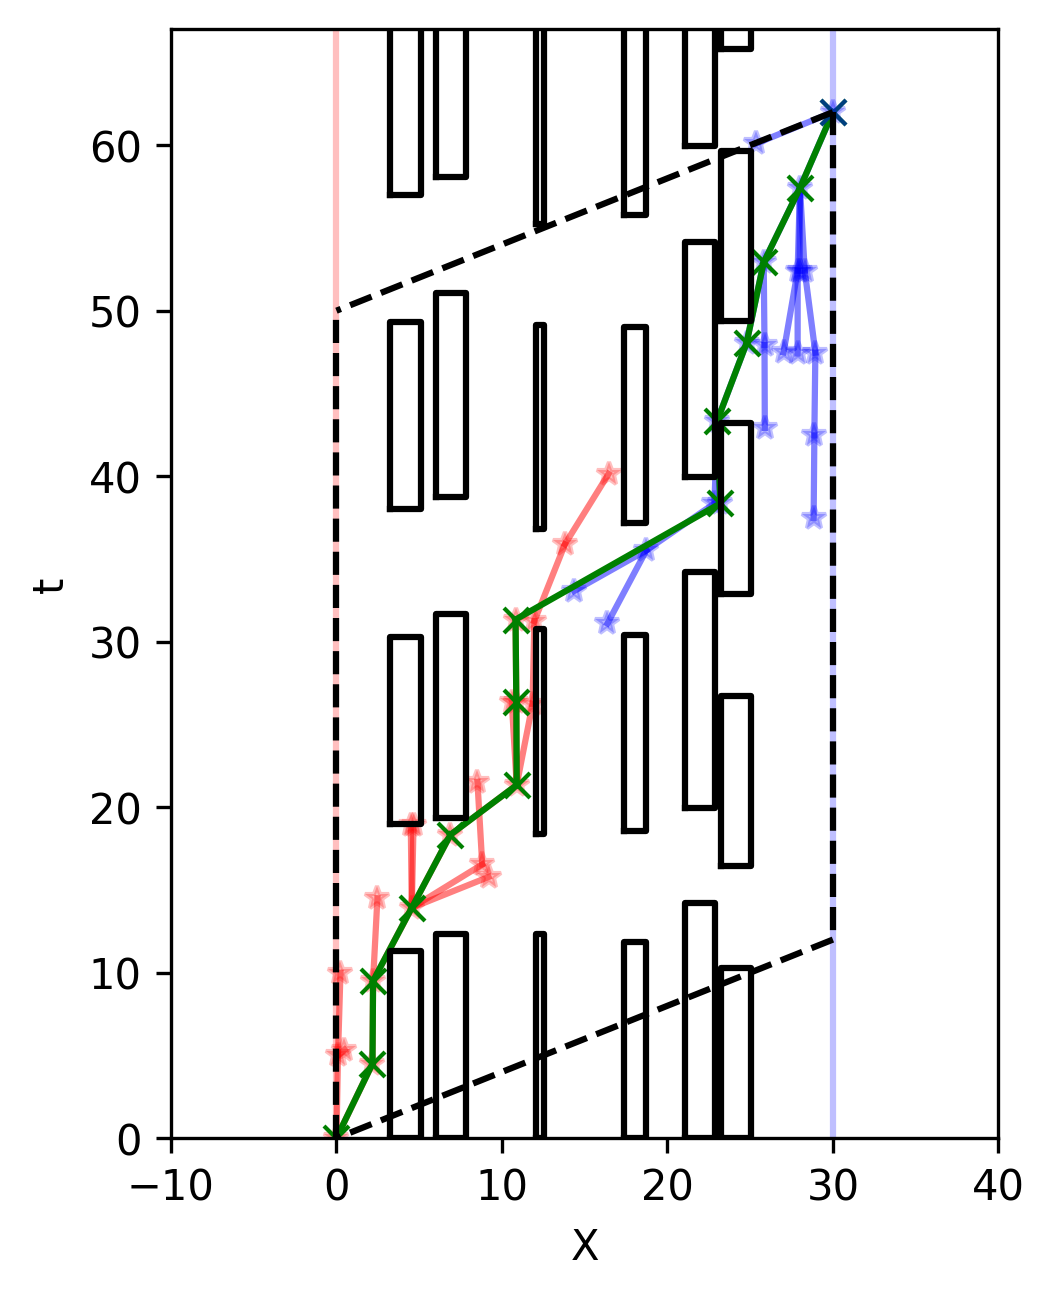

In [68]:
fig = plt.figure(dpi=300)
ax = fig.subplots()
ncounter = 2
tf = xf/vmax + 10 + 20*ncounter
# RRTConnect
for rrtv in V_RRTCa[str(ncounter)]:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrtv in V_RRTCb[str(ncounter)]:
   plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
# for rrtvr in V_RRTCa_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'm.', alpha=0.25)
# for rrtvr in V_RRTCb_raw:
#     plt.plot(rrtvr[0], rrtvr[1], 'c.', alpha=0.25)
for rrte in E_RRTCa[str(ncounter)]:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)
for rrte in E_RRTCb[str(ncounter)]:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)

if path_RRTC is not None and int(list(V_RRTCa.keys())[-1]) == ncounter:
    for pathi in path_RRTC:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(path_RRTC)-1):
        plt.plot([path_RRTC[ii][0], path_RRTC[ii+1][0]], [path_RRTC[ii][1], path_RRTC[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [x0, x0/vmax + (tf-xf/vmax)]
point4 = [xf, xf/vmax + (0-x0/vmax)]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(x0-10, xf+10)
plt.ylim(0, tf+5)
# plt.xlim(25, 35)
# plt.ylim(30, 45)
plt.xlabel('X')
plt.ylabel('t')

In [53]:
key_List = list(V_RRTCPb.keys())

Text(0, 0.5, 't')

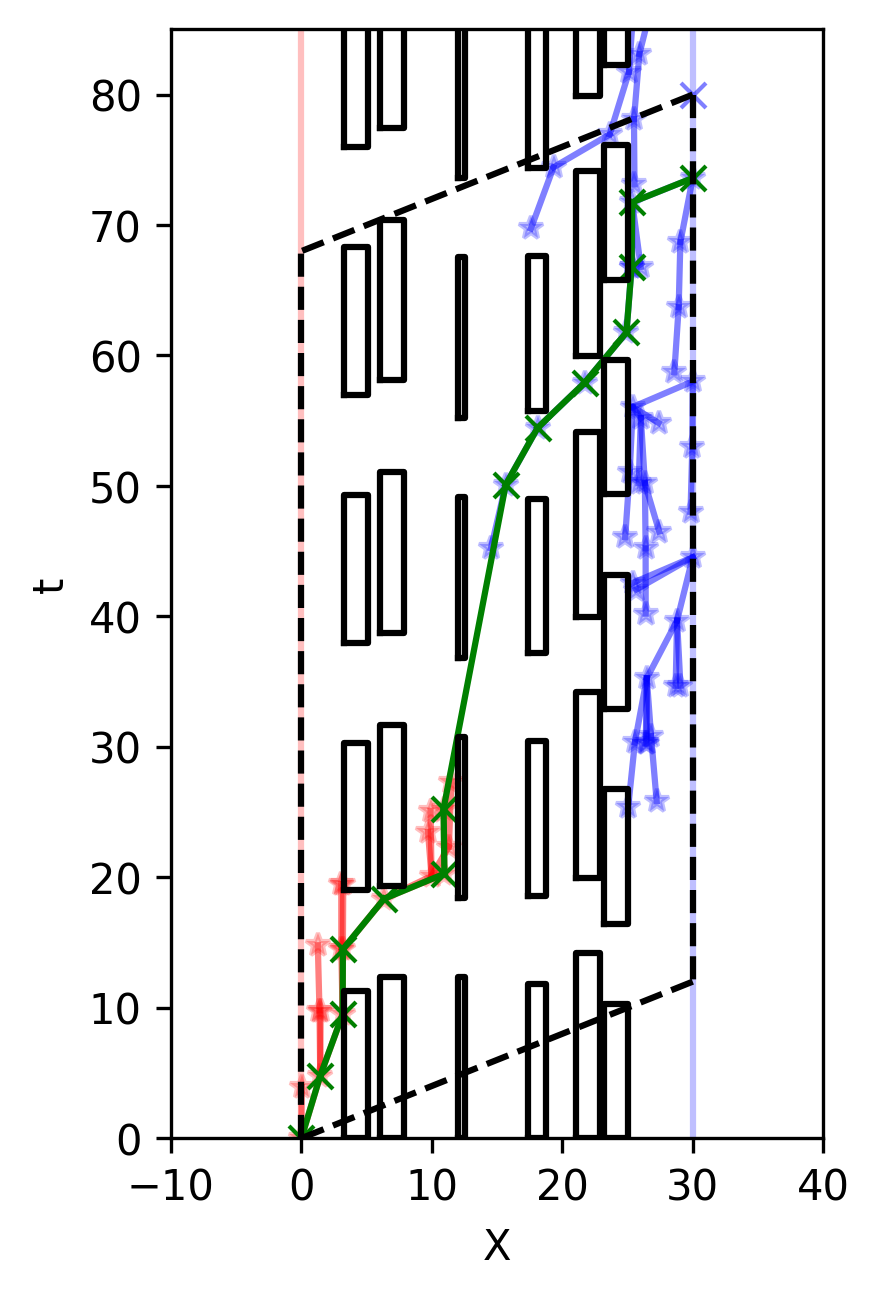

In [69]:
# pathFound, time_RRTCP, RRTCP_total_distance, RRTCP_total_time, success_RRTCP, path_RRTCP, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb

fig = plt.figure(dpi=300)
ax = fig.subplots()
ncounter = 1
tf = 80
# RRTConnect
for rrtv in V_RRTCPa:
   plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
for rrte in E_RRTCPa:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)

for ii in range(len(key_List)):
    for rrtv in V_RRTCPb[str(ii)]:
        plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
    for rrte in E_RRTCPb[str(ii)]:
        plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)

if path_RRTC is not None:
    for pathi in path_RRTCP:
        plt.plot(pathi[0], pathi[1], 'gx')
    for ii in range(len(path_RRTCP)-1):
        plt.plot([path_RRTCP[ii][0], path_RRTCP[ii+1][0]], [path_RRTCP[ii][1], path_RRTCP[ii+1][1]], '-g')


# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Initial/Final
plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
plt.plot(xf, tf, 'xb', alpha=0.5)
plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

# ST-Bound
point1 = [x0, 0]
point2 = [xf, tf]
point3 = [x0, x0/vmax + (tf-xf/vmax)]
point4 = [xf, xf/vmax + (0-x0/vmax)]
plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')

# Plot Limits
ax.axis('square')
# plt.xlim(point3[0]-5, point4[0]+5)
plt.xlim(x0-10, xf+10)
plt.ylim(0, tf+5)
# plt.xlim(25, 35)
# plt.ylim(30, 45)
plt.xlabel('X')
plt.ylabel('t')

In [74]:
from matplotlib.animation import FuncAnimation

In [70]:
key_List = list(V_RRTCa.keys())
key_Len = len(key_List)
print(key_Len)
print(len(V_RRTCa['0'])+len(V_RRTCb['0']))

3
331


In [72]:
totalPoints = 0
for ijk in range(key_Len):
    totalPoints += len(V_RRTCa[str(ijk)])
    totalPoints += len(V_RRTCb[str(ijk)])
print(totalPoints)

621


In [76]:
# Parallel RRT* TF
key_List_Parallel = list(V_RRTCPb.keys())
key_Len_Parallel = len(key_List_Parallel)
tfVec = []
for ijk in range(key_Len_Parallel):
    tfVec.append(V_RRTCPb[str(ijk)][0][1])
maxTF = np.max(tfVec)
print(maxTF)

107.64917886412151


In [78]:
totalPoints = 0
totalPoints += len(V_RRTCPa)
for ijk in range(key_Len_Parallel):
    totalPoints += len(V_RRTCPb[str(ijk)])
print(totalPoints)

84


0/126
0/126
1/126
2/126
3/126
4/126
5/126
6/126
7/126
8/126
9/126
10/126
11/126
12/126
13/126
14/126
15/126
16/126
17/126
18/126
19/126
20/126
21/126
22/126
23/126
24/126
25/126
26/126
27/126
28/126
29/126
30/126
31/126
32/126
33/126
34/126
35/126
36/126
37/126
38/126
39/126
40/126
41/126
42/126
43/126
44/126
45/126
46/126
47/126
48/126
49/126
50/126
51/126
52/126
53/126
54/126
55/126
56/126
57/126
58/126
59/126
60/126
61/126
62/126
63/126
64/126
65/126
66/126
67/126
68/126
69/126
70/126
71/126
72/126
73/126
74/126
75/126
76/126
77/126
78/126
79/126
80/126
81/126
82/126
83/126
84/126
85/126
86/126
87/126
88/126
89/126
90/126
91/126
92/126
93/126
94/126
95/126
96/126
97/126
98/126
99/126
100/126
101/126
102/126
103/126
104/126
105/126
106/126
107/126
108/126
109/126
110/126
111/126
112/126
113/126
114/126
115/126
116/126
117/126
118/126
119/126
120/126
121/126
122/126
123/126
124/126
125/126


/tmp/ipykernel_16714/4289856303.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/126


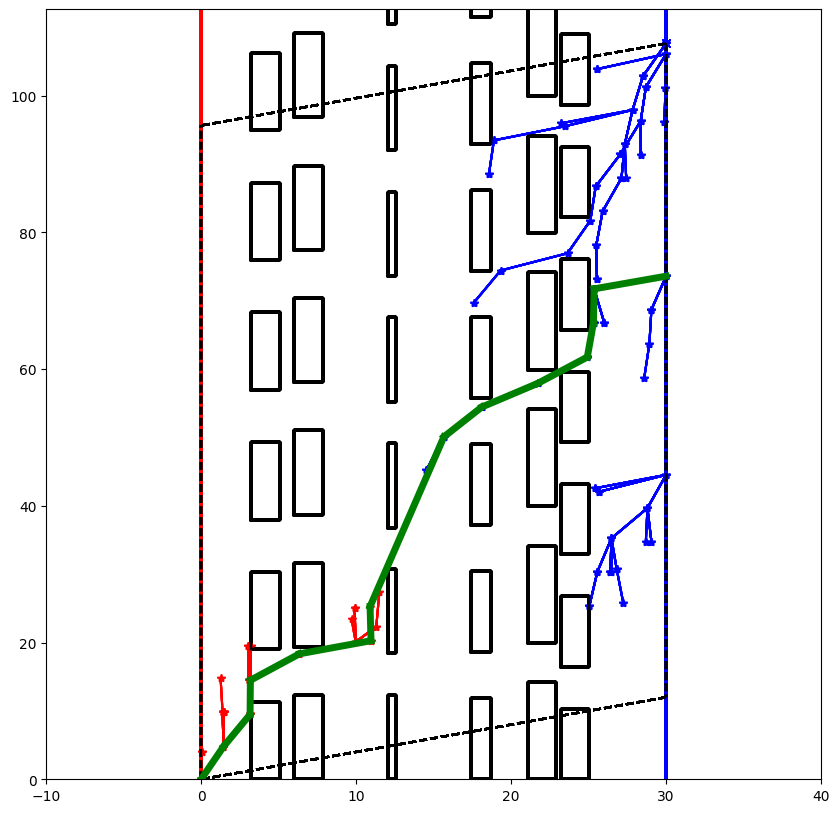

In [107]:
# Parallel RRT*
# pathFound, time_RRTCP, RRTCP_total_distance, RRTCP_total_time, success_RRTCP, path_RRTCP, V_RRTCPa, V_RRTCPb, E_RRTCPa, E_RRTCPb
tf = maxTF
figure, ax = plt.subplots()
figure.set_size_inches(10, 10)
ax.set_xlim(x0-10, xf+10)

# Key List:
key_List = list(V_RRTCPb.keys())

# Total Number of Points:
totalPoints = 0
totalPoints += len(V_RRTCPa)
for ijk in range(key_Len_Parallel):
    totalPoints += len(V_RRTCPb[str(ijk)])
pathPoints = int(totalPoints/2)

# Setting limits for x and y axis

lineAlpha = 1
lineWidth = 1
pathWidth = 5
counter = 0

# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(totalPoints+pathPoints))
    i = int(i)
    ijkl = np.mod(i, nParallel)

    ax.set_ylim(0, tf+5)

    # Init/Fin
    plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
    plt.plot(xf, tf, 'xb', alpha=0.5)
    plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

    # Obstacle
    plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
    plt.plot(xf, tf, 'xb', alpha=0.5)
    plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

    for ii in range(len(xobs)):
        obs_number = int((tf+5//np.sum(obs_vec[ii]))+1)
        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
            plt.plot(*this_obstacle.exterior.xy, 'k')

    point1 = [x0, 0]
    point2 = [xf, tf]
    point3 = [x0, x0/vmax + (tf-xf/vmax)]
    point4 = [xf, xf/vmax + (0-x0/vmax)]
    plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
    plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
    plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
    plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
    
    if ijkl == 0:
        for rrtv in V_RRTCPa[:int(i/5)]:
            plt.plot(rrtv[0], rrtv[1], 'r*', alpha=0.25)
        for rrte in E_RRTCPa[:int(i/5)]:
            plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-', alpha=0.5)

    else:
        for rrtv in V_RRTCPb[str(ijkl)][:int(i/5)]:
            plt.plot(rrtv[0], rrtv[1], 'b*', alpha=0.25)
        for rrte in E_RRTCPb[str(ijkl)][:int(i/5)]:
            plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'b-', alpha=0.5)
    
    
    if i == totalPoints:
        for pathi in path_RRTCP:
            plt.plot(pathi[0], pathi[1], '.g')
        for pathi in range(len(path_RRTCP)-1):
            plt.plot([path_RRTCP[pathi][0], path_RRTCP[pathi+1][0]], [path_RRTCP[pathi][1], path_RRTCP[pathi+1][1]], '-g', linewidth=pathWidth, zorder = 10)

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, totalPoints+pathPoints, 1), 
                        #   frames = np.arange(0, 20, 1), 
                          interval = 50)
animation.save('ParallelRRT_Example.mp4', writer="ffmpeg")
fig.show()

In [102]:
print(V_RRTCa.keys())

dict_keys(['0', '1', '2'])


0/621
0/621
1/621
2/621
3/621
4/621
5/621
6/621
7/621
8/621
9/621
10/621
11/621
12/621
13/621
14/621
15/621
16/621
17/621
18/621
19/621
20/621
21/621
22/621
23/621
24/621
25/621
26/621
27/621
28/621
29/621
30/621
31/621
32/621
33/621
34/621
35/621
36/621
37/621
38/621
39/621
40/621
41/621
42/621
43/621
44/621
45/621
46/621
47/621
48/621
49/621
50/621
51/621
52/621
53/621
54/621
55/621
56/621
57/621
58/621
59/621
60/621
61/621
62/621
63/621
64/621
65/621
66/621
67/621
68/621
69/621
70/621
71/621
72/621
73/621
74/621
75/621
76/621
77/621
78/621
79/621
80/621
81/621
82/621
83/621
84/621
85/621
86/621
87/621
88/621
89/621
90/621
91/621
92/621
93/621
94/621
95/621
96/621
97/621
98/621
99/621
100/621
101/621
102/621
103/621
104/621
105/621
106/621
107/621
108/621
109/621
110/621
111/621
112/621
113/621
114/621
115/621
116/621
117/621
118/621
119/621
120/621
121/621
122/621
123/621
124/621
125/621
126/621
127/621
128/621
129/621
130/621
131/621
132/621
133/621
134/621
135/621
136/621
137/621


/tmp/ipykernel_16714/2289904862.py:193: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0/621


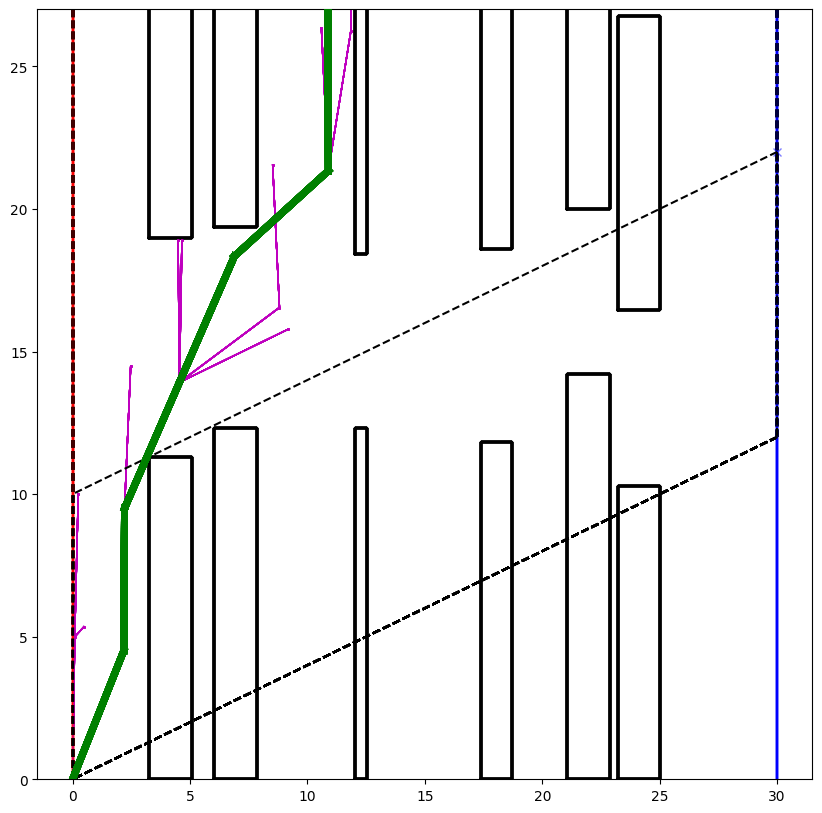

In [106]:
# STRRT*
figure, ax = plt.subplots()
figure.set_size_inches(10, 10)
ax.set_xlim(x0-10, xf+10)

# Key List:
key_List = list(V_RRTCa.keys())

# Total Number of Points:
totalPoints = 0
for ijk in range(key_Len):
    totalPoints += len(V_RRTCa[str(ijk)])
    totalPoints += len(V_RRTCb[str(ijk)])

# Setting limits for x and y axis

lineAlpha = 1
lineWidth = 1
pathWidth = 5

# Since plotting a single graph
def animation_function(i):
    print(str(i)+'/'+str(totalPoints))
    i = int(i)
    # Initial/Final
    
    # ST-Bound
    if i < len(V_RRTCa['0'])+len(V_RRTCb['0']):
        tf = xf/vmax + 10
        
        # Init
        plt.plot([x0, x0], [0, tf+5], 'r-', alpha=0.25)
        plt.plot(xf, tf, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf+5], 'b-', alpha=0.25)

        for ii in range(len(xobs)):
            obs_number = int((tf+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        if np.mod(i, 2) == 0:
            for rrte in V_RRTCa['0'][:int(i/2)]:
                plt.plot(rrte[0], rrte[1], '.m', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCa['0'][:int(i/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'm-', alpha=lineAlpha, linewidth=lineWidth)
        else:
            for rrte in V_RRTCb['0'][:int(i/2)]:
                plt.plot(rrte[0], rrte[1], '.c', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCb['0'][:int(i/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'c-', alpha=lineAlpha, linewidth=lineWidth)
        point1 = [x0, 0]
        point2 = [xf, tf]
        point3 = [x0, x0/vmax + (tf-xf/vmax)]
        point4 = [xf, xf/vmax + (0-x0/vmax)]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        ax.set_ylim(0, tf+5)
    elif i == len(V_RRTCa['0'])+len(V_RRTCb['0']):
        plt.cla()
        tf1 = xf/vmax + 10 + 20

        # Init
        plt.plot([x0, x0], [0, tf1+5], 'r-', alpha=0.25)
        plt.plot(xf, tf1, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf1+5], 'b-', alpha=0.25)

        ij = i - (len(V_RRTCa['0'])+len(V_RRTCb['0']))

        for ii in range(len(xobs)):
            obs_number = int((tf1+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        point1 = [x0, 0]
        point2 = [xf, tf1]
        point3 = [x0, x0/vmax + (tf1-xf/vmax)]
        point4 = [xf, xf/vmax + (0-x0/vmax)]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        ax.set_ylim(0, tf1+5)
    elif i >= len(V_RRTCa['0'])+len(V_RRTCb['0']) and i < len(V_RRTCa['0'])+len(V_RRTCb['0'])+len(V_RRTCa['1'])+len(V_RRTCb['1']):
        # ax.clear()
        tf1 = xf/vmax + 10 + 20

        # Init
        plt.plot([x0, x0], [0, tf1+5], 'r-', alpha=0.25)
        plt.plot(xf, tf1, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf1+5], 'b-', alpha=0.25)

        ij = i - (len(V_RRTCa['0'])+len(V_RRTCb['0']))

        for ii in range(len(xobs)):
            obs_number = int((tf1+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        if np.mod(ij, 2) == 0:
            for rrte in V_RRTCa['1'][:int(ij/2)]:
                plt.plot(rrte[0], rrte[1], '.m', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCa['1'][:int(ij/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'm-', alpha=lineAlpha, linewidth=lineWidth)
        else:
            for rrte in V_RRTCb['1'][:int(ij/2)]:
                plt.plot(rrte[0], rrte[1], '.c', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCb['1'][:int(ij/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'c-', alpha=lineAlpha, linewidth=lineWidth)
        point1 = [x0, 0]
        point2 = [xf, tf1]
        point3 = [x0, x0/vmax + (tf1-xf/vmax)]
        point4 = [xf, xf/vmax + (0-x0/vmax)]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        ax.set_ylim(0, tf1+5)
    elif i == len(V_RRTCa['0'])+len(V_RRTCb['0'])+len(V_RRTCa['1'])+len(V_RRTCb['1']):
        plt.cla()
        tf2 = xf/vmax + 10 + 20*2

        # Init
        plt.plot([x0, x0], [0, tf2+5], 'r-', alpha=0.25)
        plt.plot(xf, tf2, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf2+5], 'b-', alpha=0.25)

        ij = i - (len(V_RRTCa['0'])+len(V_RRTCb['0']))

        for ii in range(len(xobs)):
            obs_number = int((tf2+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        point1 = [x0, 0]
        point2 = [xf, tf2]
        point3 = [x0, x0/vmax + (tf2-xf/vmax)]
        point4 = [xf, xf/vmax + (0-x0/vmax)]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        ax.set_ylim(0, tf2+5)
    elif i >= len(V_RRTCa['0'])+len(V_RRTCb['0'])+len(V_RRTCa['1'])+len(V_RRTCb['1']) and \
        i < len(V_RRTCa['0'])+len(V_RRTCb['0'])+len(V_RRTCa['1'])+len(V_RRTCb['1'])+len(V_RRTCa['2'])+len(V_RRTCb['2']):
        tf2 = xf/vmax + 10 + 20*2

        # Init
        plt.plot([x0, x0], [0, tf2+5], 'r-', alpha=0.25)
        plt.plot(xf, tf2, 'xb', alpha=0.5)
        plt.plot([xf, xf], [0, tf2+5], 'b-', alpha=0.25)

        ijj = i - (len(V_RRTCa['0'])+len(V_RRTCb['0']))

        for ii in range(len(xobs)):
            obs_number = int((tf2+5//np.sum(obs_vec[ii]))+1)
            for j in range(obs_number):
                this_obstacle = time_block_obstacle(xobs[ii], obs_vec[ii], j)
                plt.plot(*this_obstacle.exterior.xy, 'k')
        if np.mod(ijj, 2) == 0:
            for rrte in V_RRTCa['2'][:int(ijj/2)]:
                plt.plot(rrte[0], rrte[1], '.m', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCa['2'][:int(ijj/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'm-', alpha=lineAlpha, linewidth=lineWidth)
        else:
            for rrte in V_RRTCb['2'][:int(ijj/2)]:
                plt.plot(rrte[0], rrte[1], '.c', alpha=lineAlpha, markersize=lineWidth)
            for rrte in E_RRTCb['2'][:int(ijj/2)]:
                plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'c-', alpha=lineAlpha, linewidth=lineWidth)
        point1 = [x0, 0]
        point2 = [xf, tf2]
        point3 = [x0, x0/vmax + (tf2-xf/vmax)]
        point4 = [xf, xf/vmax + (0-x0/vmax)]
        plt.plot([point1[0], point3[0]], [point1[1], point3[1]], '--k')
        plt.plot([point2[0], point3[0]], [point2[1], point3[1]], '--k')
        plt.plot([point2[0], point4[0]], [point2[1], point4[1]], '--k')
        plt.plot([point4[0], point1[0]], [point4[1], point1[1]], '--k')
        ax.set_ylim(0, tf2+5)
    elif i >= len(V_RRTCa['0'])+len(V_RRTCb['0'])+len(V_RRTCa['1'])+len(V_RRTCb['1'])+len(V_RRTCa['2'])+len(V_RRTCb['2']):
        for pathi in path_RRTC:
            plt.plot(pathi[0], pathi[1], '.g')
        for pathi in range(len(path_RRTC)-1):
            plt.plot([path_RRTC[pathi][0], path_RRTC[pathi+1][0]], [path_RRTC[pathi][1], path_RRTC[pathi+1][1]], '-g', linewidth=pathWidth, zorder = 10)

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(0, totalPoints+20, 1), 
                        #   frames = np.arange(totalPoints-10, totalPoints+10, 1), 
                        #   frames = np.arange(0, 50, 1), 
                          interval = 100)
animation.save('STRRT_Example.mp4', writer="ffmpeg")
fig.show()